# Simple RNN

In ths notebook, we're going to train a simple RNN to do **time-series prediction**. Given some set of input data, it should be able to generate a prediction for the next time step!
<img src='assets/time_prediction.png' width=40% />

> * First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

### Import resources and create data 

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## This line of code ensures the reproducibility of the code
torch.manual_seed(42)

In [2]:
## testing out how we are going to generate the data points
degs = np.linspace(0, 180, 19)
rads = degs*np.pi/180
sin_results = np.sin(rads)

print(f'The angles in rad are:\n{rads}\n')
print(f'The angles in degrees are:\n{degs}\n')
print('\n' + '='*100 + '\n')
print(f'The Sine of the angles are:\n{sin_results}')

The angles in rad are:
[0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633 1.74532925 1.91986218
 2.0943951  2.26892803 2.44346095 2.61799388 2.7925268  2.96705973
 3.14159265]

The angles in degrees are:
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180.]



The Sine of the angles are:
[0.00000000e+00 1.73648178e-01 3.42020143e-01 5.00000000e-01
 6.42787610e-01 7.66044443e-01 8.66025404e-01 9.39692621e-01
 9.84807753e-01 1.00000000e+00 9.84807753e-01 9.39692621e-01
 8.66025404e-01 7.66044443e-01 6.42787610e-01 5.00000000e-01
 3.42020143e-01 1.73648178e-01 1.22464680e-16]


The data generation process in the next cell is following these steps:
1. Generate equally spaced values between **0** and **pi "consider them as angels between 0 and 180 degrees"**.
2. Apply the **sine** function over each of the generated values "so the output will always be between -1 and 1 which is the range of output of the sine function".
3. The `features` will be the **sine output** of the number and the `labels` will be also the **sine output** but of the next number, so as if it's a one time step ahead in the future.

the shape of x is: (20, 1)
the shape of y is: (20, 1)


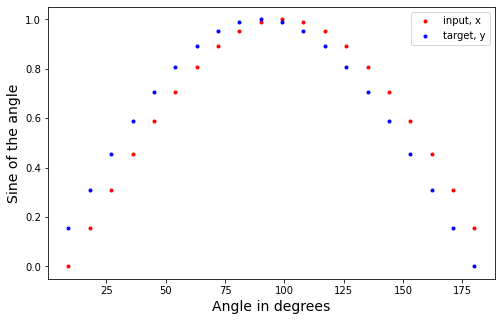

In [3]:
# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, 180, seq_length + 1)  ## generated 21 points
data = np.sin(time_steps*np.pi/180)  ## still 21 values
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension
## the above line is an inline operation, so resize changes the shape of the data variable
## another approach is:
## data = data.reshape(seq_length + 1, 1)

x = data[:-1] # all but the last piece of data
print('the shape of x is:', x.shape)
y = data[1:] # all but the first
print('the shape of y is:', y.shape)

# display the data
plt.figure(figsize=(8,5))
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.xlabel('Angle in degrees', fontsize=14)
plt.ylabel('Sine of the angle', fontsize=14)

plt.show()

---
## Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, num_features)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [4]:
## Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x is of shape: (batch_size, seq_length, input_size=num_features)
        # hidden is of shape: (n_layers, batch_size, hidden_dim)
        # r_out is of shape: (batch_size, time_step, hidden_size)
        batch_size = x.shape[0]
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

In [5]:
## Define the same RNN model from above but this time it's a debugging version
## So, this version prints the shape of input, hidden and output tensors at each step
class RNN_debug(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x is of shape: (batch_size, seq_length, input_size=num_features)
        # hidden is of shape: (n_layers, batch_size, hidden_dim)
        # r_out is of shape: (batch_size, time_step, hidden_size)
        batch_size = x.shape[0]
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        print(f'The shape of the RNN hidden state is: {hidden.shape}')
        print('And the hidden state is:')
        print(hidden)
        print(f'\nThe shape of the RNN output before any format is: {r_out.shape}')
        print('And the untouched output is:')
        print(r_out)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)
        print(f'\nThe shape of the RNN output after the format is: {r_out.shape}')
        print('And the formatted output is:')
        print(r_out)
        
        # get final output 
        output = self.fc(r_out)
        print(f'\nThe shape of the FC output is: {output.shape}')
        print('And the FC output is:')
        print(output)
        
        return output, hidden

### Check the input and output dimensions

As a check that your model is working as expected, test out how it responds to input data.

In [6]:
# Creating an instance of the model
test_rnn = RNN_debug(input_size=1, output_size=1, hidden_dim=5, n_layers=3)

# generate evenly spaced, test data points
seq_length = 8
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))  ## adding an extra dimension so the data shape is (20 x 1)

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension => shape = (1 x 20 x 1)
print('The input size before feeding the input to the network: ', test_input.size())
print('And the input is:')
print(f'{test_input}\n')

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)  ## using the forward method without writing .forward

The input size before feeding the input to the network:  torch.Size([1, 8, 1])
And the input is:
tensor([[[0.0000e+00],
         [4.3388e-01],
         [7.8183e-01],
         [9.7493e-01],
         [9.7493e-01],
         [7.8183e-01],
         [4.3388e-01],
         [1.2246e-16]]])

The shape of the RNN hidden state is: torch.Size([3, 1, 5])
And the hidden state is:
tensor([[[ 0.7991,  0.1572,  0.5992,  0.0689, -0.4188]],

        [[ 0.4612,  0.4897, -0.8325, -0.1426, -0.4140]],

        [[-0.1722, -0.0886,  0.3337,  0.2658,  0.3435]]],
       grad_fn=<StackBackward>)

The shape of the RNN output before any format is: torch.Size([1, 8, 5])
And the untouched output is:
tensor([[[-0.2885,  0.0350,  0.1393,  0.0172,  0.2007],
         [-0.2364, -0.0781,  0.2343,  0.1595,  0.2335],
         [-0.2276, -0.1336,  0.3397,  0.2171,  0.2824],
         [-0.2370, -0.1931,  0.3488,  0.2645,  0.3053],
         [-0.2105, -0.2029,  0.3860,  0.2730,  0.3053],
         [-0.2123, -0.1916,  0.3761,  0.292

### Explaining the `Tensor Dimensions` for the `RNN`
#### Regarding the Inputs

- **`sequence length`**: The number of elements in the sequence, for instance if we are feeding the network a **vector** of **length = 20** then our **sequence length** is 20
- **`input_size`**: The number of features in our data, if the data is fed to the network as one element **"feautre"** per time step, then the **input_size = 1**, if we are feeding the network 2 elements per time step "let's say one element is the stock price in Canada and the other element is the CAD to USD value at that time", then the **input_size = 2** as we will be feeding the network 2 features per time step
- **`batch_first`**: A boolean of whether to include the **batch_size** as the first dimension or not, if we set it to **True** and each batch has 1 **input sequence** then the **batch_size = 1**

#### Regarding the Training Process and the RNN Output
**At each time step:**
- The model will look at one element of the input sequence
- The model will generate a number of hidden state vectors, each vector will have length = **`hidden_dim`**
- The number of the generated hidden state vectors = **`n_layers`** which is the number of layers of the RNN we have specified
- The hidden state vector of the last hidden layer is the output of the RNN and it's what will be fed to the fully connected layer
- The output of the RNN after iterating over all the elements of the **input sequence** = all the hidden states of the last layer at each time step and that's why the RNN output has the following shape: **`batch size X sequence length X hidden state vector length`**

#### Regarding the Hidden State
- The model expects the user to define the length of the hidden state vector
- The initial hidden state vector fed to the network can be set to **None**
- The hidden state at each time step is of the shape: **`number of RNN layers X batch size X hidden state vector length`**

#### Regarding the Final Output
- If the batch size = 1, then the final outputs of the Fully Connected layer is of shape: **`sequence length X output size`**

---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [7]:
# decide on hyperparameters
seq_length=18
input_size=1 
output_size=1
hidden_dim=32
n_layers=3

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.

In [8]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the RNN, we get the latest hidden state, and use that as input to the RNN for the following steps

In [9]:
# train the RNN
def train(rnn, n_steps, print_every, GPU=False):
    """this function takes the following inputs:
    rnn: the model
    n_steps: the number of training epochs
    print_every: an integer to print every certain number of steps
    GPU: a boolean to either use GPU or CPU in training
    """
    if GPU:
        device = 'cuda'
    else:
        device='cpu'
    
    # initialize the hidden state
    hidden = None
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps_deg = np.linspace(step*180, (step+1)*180, seq_length + 1)
        time_steps = time_steps_deg * np.pi/180
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)
        
        ## moving the model and the data to the device (either cpu or gpu)
        rnn.to(device)
        x_tensor = x_tensor.to(device)
        y_tensor = y_tensor.to(device)
        
        ## the initial hidden state = None which can't be moved to the GPU
        ## so using this try except block to avoid raising an error
        try:
            hidden = hidden.to(device)
        except:
            pass

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        # hidden = hidden.data
        hidden.detach_()

        # zero gradients
        optimizer.zero_grad()
        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
    
            plt.figure(figsize=(8,5))
            
            plt.plot(time_steps_deg[1:], x, 'r.', label='input, x') # input
            plt.plot(
                time_steps_deg[1:], prediction.cpu().data.numpy().flatten(),
                'b.', label='target, y') # predictions
            
            plt.legend(loc='best')
            plt.xlabel('Angle in degrees', fontsize=14)
            plt.ylabel('Sine of the angle', fontsize=14)

            plt.show()

    return rnn

Loss:  0.4605722427368164


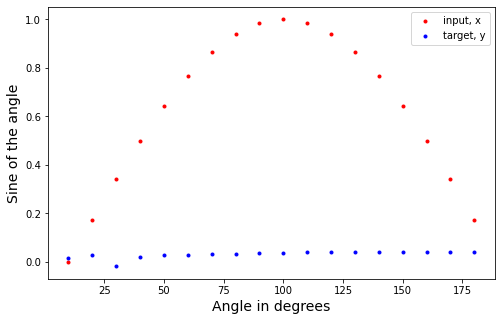

Loss:  0.014374567195773125


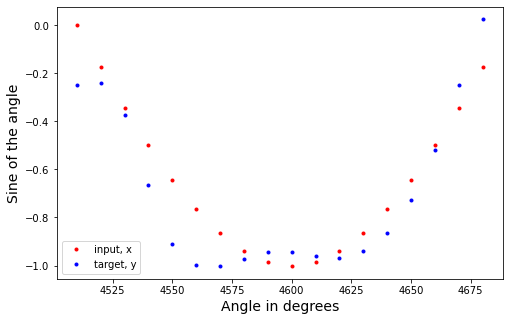

Loss:  0.004883641377091408


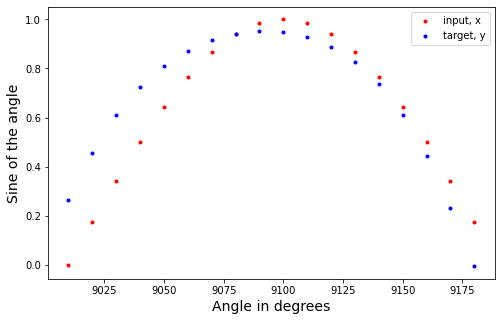

Loss:  0.001172502525150776


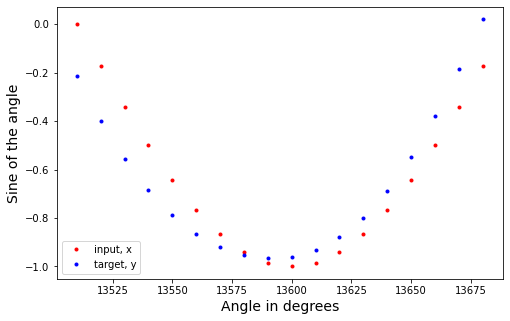

Loss:  0.000737941765692085


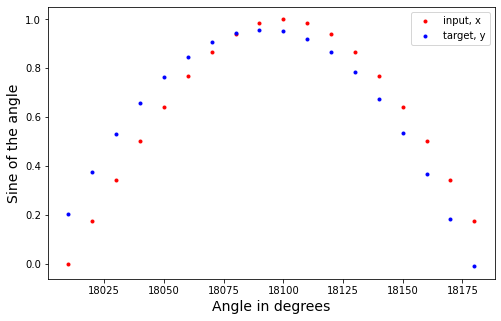

Loss:  0.00043186324182897806


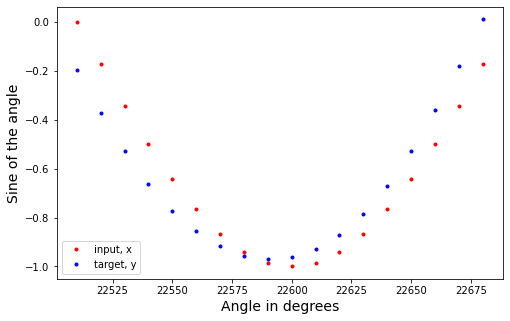

In [10]:
# train the rnn and monitor results
n_steps = 150
print_every = 25

trained_rnn = train(rnn, n_steps, print_every, GPU=True)

After training the model for **150 steps** we can see the model predicted values **"points with the blue color"** are of the same shape as the input sequences **"points with the red color"** but with just 1 time step difference. Now, it's time to test the model on a sequence of range = 360 degrees and with much more points to make sure some of these points never got seen by the model before

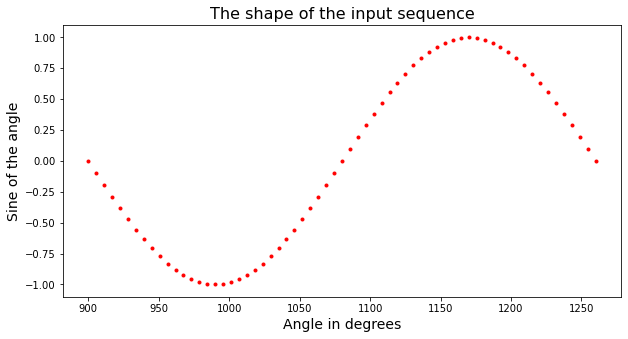

In [11]:
test_steps = np.linspace(5*180, 7*180, 65)
test_seq = np.sin(test_steps * np.pi/180)

plt.figure(figsize=(10,5))

plt.plot(test_steps, test_seq, 'r.', label='test sequence')

plt.xlabel('Angle in degrees', fontsize=14)
plt.ylabel('Sine of the angle', fontsize=14)
plt.title('The shape of the input sequence', fontsize=16)

plt.show()

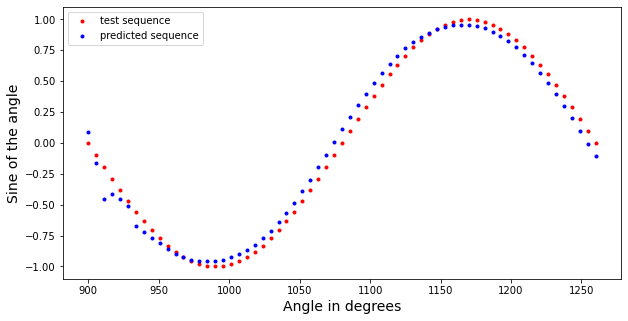

In [12]:
## Moving the model to the CPU
trained_rnn.cpu()

## Formatting the test sequence to be fed to the model
test_seq_formatted = torch.Tensor(test_seq).unsqueeze(1).unsqueeze(0)

## Feeding the sequence to the model
test_outputs, current_h = trained_rnn(test_seq_formatted, None)

## Formatting the model outputs
test_outputs = test_outputs.detach().numpy().flatten()

## Plotting the predicted values against the input sequence
plt.figure(figsize=(10,5))

plt.plot(test_steps, test_seq, 'r.', label='test sequence')
plt.plot(test_steps, test_outputs, 'b.', label='predicted sequence')

plt.legend(loc='best')
plt.xlabel('Angle in degrees', fontsize=14)
plt.ylabel('Sine of the angle', fontsize=14)

plt.show()

We can see that, the first few predictions in the sequence are bad compared to the rest of the sequence. The reason for this is when the model starts seeing the data, it has no memory **"we passed an initial hidden state = None"**, and the model builds its memory more and more each time it sees a new data point of the sequence data points. To avoid this issue we use what we can call **Priming**, the aim of **Priming** is to build up the model's memory before testing on a new sequence. We will see more about **Priming** in the upcoming notebook about **LSTM cells**.

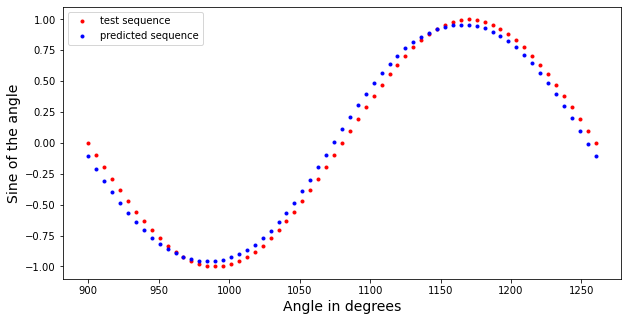

In [13]:
## Creating a prime sequence
prime_steps = np.linspace(4*180, 5*180-5.625, 32)
prime_seq = np.sin(prime_steps * np.pi/180)

## Building up a memory for the model
_, current_h = trained_rnn(torch.Tensor(prime_seq).unsqueeze(1).unsqueeze(0), None)

## Feeding the test sequence to the model after building up the memory along with this memory
test_outputs, current_h = trained_rnn(test_seq_formatted, current_h)

## Formatting the model outputs
test_outputs = test_outputs.detach().numpy().flatten()

## Plotting the predicted values against the input sequence
plt.figure(figsize=(10,5))

plt.plot(test_steps, test_seq, 'r.', label='test sequence')
plt.plot(test_steps, test_outputs, 'b.', label='predicted sequence')

plt.legend(loc='best')
plt.xlabel('Angle in degrees', fontsize=14)
plt.ylabel('Sine of the angle', fontsize=14)

plt.show()

We can clearly see that, after building up the model's memory, the predictions are much better for the early time steps. However, building the model's memory depends on the length of the **Prime Sequence** and the distance between the points of the sequence. In my case here, I set the distance between the points of the **Prime Sequence** just like the distance between the points of the **Test Sequence**.

**Note**: There is an attached **HTML file** with **Plotly** interactive graphs, you can check it out if you would like to zoom in the graphs and get the value for each data point.